# Image Manipulation Notebook

This notebook contains cells for manipulating and inspecting an image.
The functions of the notebook include:

* Hue Modification
* Color Channel Selection
* Color Channel Histograms
* Image Luminance Value Threshold 
* Image Edge Detection

This notebook was created and tested using the following packages and versions:
* Python 3.6.1
* IPython 5.3.0
* Jupyter Notebook 5.0.0 
* Matplotlib 2.0.2
* NumPy 1.12.1
* IPyWidgets 6.0.0

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import ipywidgets as widgets
import os
import image_tools as it
from IPython.display import (display, clear_output)

%matplotlib inline
%load_ext image_magics

### Image loading

The following cell displays a text input for the image file to manipulate

* When the image is found it will be displayed below the textbox
* This image will be used in the following cells

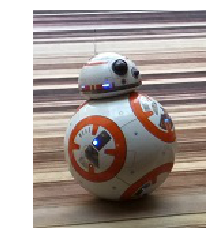

In [2]:
global editing_image
editing_image = mpimg.imread('../data/examples/sample.jpg')/255
plt.axis('off')
plt.imshow(editing_image)

tb = widgets.Text(
    value='../data/examples/sample.jpg',
    description='Image File',
    continuous_update=False)

def tb_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        file = change['new']
        if os.path.isfile(file):
            global editing_image
            editing_image = mpimg.imread(file)
            editing_image = editing_image.astype(np.float)/255
            plt.axis('off')
            plt.imshow(editing_image)
   
tb.observe(tb_on_change)
display(tb)

### Hue modification

The next cell can be used to change the hue value of the loaded image.

1. The hue, saturation, and value are calculated for the image.
2. The slider is used to update the hue
3. The hue, saturation, and value are converted back to RGB
4. The RGB image is displayed

The following formulas are used for conversion:

If the raw image is scaled from 0 to 255 its rescaled to 0..1
$$ R' = R/255 $$
$$ G' = G/255 $$
$$ B' = B/255 $$

$$ Cmax = max(R', G', B') $$
$$ Cmin = min(R', G', B') $$
$$ \Delta = Cmax - Cmin $$

Hue calculation:
$$ H = \begin{cases}
            0 & \Delta = 0 \\
            60 \times \left( \frac{G'-B'}{\Delta}mod6 \right) & Cmax = R' \\
            60 \times \left( \frac{B'-R'}{\Delta} + 2 \right) & Cmax = G' \\
            60 \times \left( \frac{R'-G'}{\Delta} + 4 \right) & Cmax = B'
        \end{cases}$$

Saturation calculation:
$$ S = \begin{cases}
            0 & Cmax = 0 \\
            \frac{\Delta}{Cmax} & Cmax \neq 0
       \end{cases} $$

Value calculation:
$$ V = Cmax $$


Formula can be found at [Rapidtables](www.rapidtables.com/convert/color/rgb-to-hsv.htm)

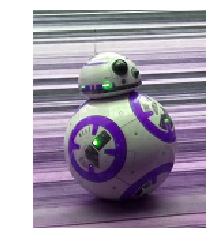

In [3]:
global hue_image
hue_image = np.copy(editing_image)
plt.axis('off')
plt.imshow(hue_image)

hfs = widgets.FloatSlider(
    value=0,
    min=-0.5,
    max=0.5,
    step=0.01,
    description="Hue",
    disabled=False,
    continuous_update=False,
    orientation='horizontal')

def hfs_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global editing_image
        global hue_image
        clear_output()
        val = change['new']
        hsv = it.rgb_to_hsv(editing_image)
        hue = it.change_hue(hsv, val)
        hue_image = it.hsv_to_rgb(hue)
        plt.axis('off')
        plt.imshow(hue_image)
    
hfs.observe(hfs_on_change)
display(hfs)

In [4]:
def show_channel_image_and_histogram(image, channel):
    """Selects a specified color channel of an image and displays it and the histogram for that color
    
    Arguments:
        * image: NumPy 3D array (Height, Width, Color)
        * channel: Integer number corresponding to color (0=Red, 1=Green, 2=Blue)
        
    Returns:
        * None        
    """
    gray_scale = np.zeros(image.shape, dtype=image.dtype)
    gray_scale[:,:,0] = image[:,:,channel]
    gray_scale[:,:,1] = image[:,:,channel]
    gray_scale[:,:,2] = image[:,:,channel]
    f, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
    ax1.axis('off')
    ax1.imshow(gray_scale)
    ax2.hist(image[:,:,channel].ravel()*255, bins=np.arange(0, 256, 5))

### Color Channel Selection

The following cell can be used to select the different color channels of the loaded image.

Use the dropdown box to pick a color channel.

A grey scale image of that color channel will be display as well as the histogram for that color channel.

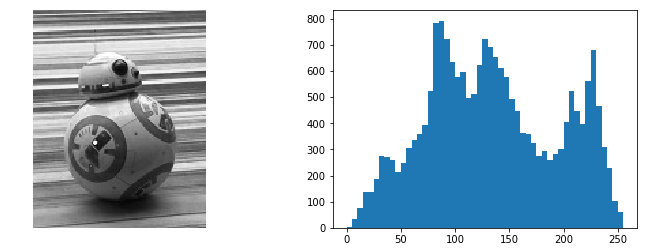

In [5]:
dw = widgets.Dropdown(
    options={'Red Channel': 0, 'Green Channel': 1, 'Blue Channel': 2},
    value=2,
    description='Color Channel')

def dw_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        clear_output()
        val = change['new']
        show_channel_image_and_histogram(hue_image, val)
    
dw.observe(dw_on_change)
display(dw)

### Exporting the modified image

The following cell can be used to export the hue modified image

Then using the next cell the exported images can be view within the notebook

In [6]:
it.export_color_channels(hue_image)

In [7]:
%%print_pics 3
../data/processed/channel_red.png
../data/processed/channel_green.png
../data/processed/channel_blue.png

In [8]:
def show_threshold_image(image, threshold, invert):
    """Runs the threshold algorithmn on the image and displays the image
    
    Arguments:
        * image: NumPy 3D array
        * threshold:  The threshold value
        * invert: Boolean to swap black and white
    Returns:
        * thres_image: Threshold image         
    """
    hsv = it.rgb_to_hsv(image)
    thres = it.value_threshold(hsv, threshold, invert)
    thres_image = it.hsv_to_rgb(thres)
    plt.axis('off')
    plt.imshow(thres_image)
    return thres_image

### Image Threshold
The next cell runs a threshold detection algorithmn on the selected image.

The image is first converted from RGB to HSV.

Pixels that have a Value above the threshold are white and black if they are below.

The colors are inverted if the 'Invert Threshold' button is pressed.

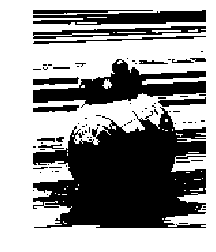

In [9]:
global threshold_invert
global threshold_image
global threshold_value
threshold_value = 0.5
threshold_invert = False
threshold_image = show_threshold_image(editing_image, threshold_value, threshold_invert)

tfs = widgets.FloatSlider(
    value=0.5,
    min=0.0,
    max=1.0,
    step=0.01,
    description="Threshold",
    disabled=False,
    continuous_update=False,
    orientation='horizontal')

def tfs_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global editing_image
        global threshold_image
        global threshold_value
        clear_output()
        threshold_value = change['new']
        threshold_image = show_threshold_image(editing_image, threshold_value, threshold_invert)
        
ttb = widgets.ToggleButton(
    value=False,
    description='Invert Threshold',
    disabled=False)

def ttb_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global editing_image
        global threshold_image
        global threshold_invert
        clear_output()
        threshold_invert = change['new']
        threshold_image = show_threshold_image(editing_image, threshold_value, threshold_invert)

ttb.observe(ttb_on_change)  
tfs.observe(tfs_on_change)
thres_controls = widgets.HBox([tfs, ttb])
display(thres_controls)

In [10]:
def run_edge_detection(image, filter_size, gray_scale):
    """Runs edge detection on the image and displays the image
    
    Arguments:
        * image: NumPy 3D array (in RGB)
        * filter_size: 0 for 3x3 or 1 for 5x5 Laplacian
        * gray_scale: Boolean for selecting gray scale output
    Returns:
        * edge_image: edge detected image         
    """
    conv = np.array([])
    if filter_size == 0:
        conv = np.array([[-1, -1, -1],[-1, 8, -1],[-1,-1,-1]])
    else:
        conv = np.array([[-1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1],
                  [-1, -1, 24, -1, -1],
                  [-1, -1, -1, -1, -1],
                  [-1, -1, -1, -1, -1]])    
    if gray_scale:
        convolution = it.convolve_image(it.grayscale(image), conv)
    else:
        convolution = it.convolve_image(image, conv)
    plt.axis('off')
    plt.imshow(convolution)
    return convolution

### Edge Detection
The next cell can be used to run edge detection on the selected image.

The edge detection algorithmn uses convolution over the image to detect edges.

The cell allows for a 3x3 and 5x5 Laplacian matrix to be used as the convolution filter. 

The 3x3 filter is:

|  |  |  |
|--|--|--|
|-1|-1|-1|
|-1| 8|-1|
|-1|-1|-1|  

The 5x5 filter is:

|  |  |  |  |  |
|--|--|--|--|--|
|-1|-1|-1|-1|-1|
|-1|-1|-1|-1|-1|
|-1|-1|24|-1|-1| 
|-1|-1|-1|-1|-1|
|-1|-1|-1|-1|-1|


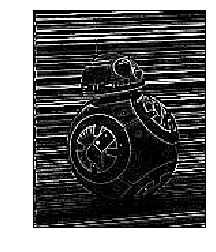

In [11]:
global edge_image
global edge_filter_size
global edge_filter_gray
edge_filter_size = 0
edge_filter_gray = False
edge_image = run_edge_detection(editing_image, edge_filter_size, edge_filter_gray)

eddd = widgets.Dropdown(
    options={'3x3 Laplacian': 0, '5x5 Laplacian': 1},
    value=0,
    description='Edge Detection Size')

def eddd_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global edge_image
        global edge_filter_size
        clear_output()
        edge_filter_size = change['new']
        edge_image = run_edge_detection(editing_image, edge_filter_size, edge_filter_gray)

edtb = widgets.ToggleButton(
    value=False,
    description='Use grayscale',
    disabled=False)

def edtb_on_change(change):
    if change['type'] == 'change' and change['name'] == 'value':
        global edge_image
        global edge_filter_gray
        clear_output()
        edge_filter_gray = change['new']
        edge_image = run_edge_detection(editing_image, edge_filter_size, edge_filter_gray)


eddd.observe(eddd_on_change)
edtb.observe(edtb_on_change)
edge_controls = widgets.HBox([eddd, edtb])
display(edge_controls)

In [12]:
mpimg.imsave('../data/processed/hue.png', hue_image)
mpimg.imsave('../data/processed/threshold.png', threshold_image)
mpimg.imsave('../data/processed/edge.png', edge_image)

In [13]:
%print_pic ../data/examples/robot2.jpg

In [14]:
%%print_pics 3
../data/processed/hue.png
../data/processed/threshold.png
../data/processed/edge.png